In [1]:
# Data handling
import numpy as np
import pandas as pd
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import graphviz
import optuna
import optuna.visualization as vis
%matplotlib inline

# Stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import shapiro, norm, chi2_contingency

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

#lib
from lib.clean_data_functions import clean_ext_version, clean_ext_publisher, clean_repo_publisher

#
from wordcloud import WordCloud,STOPWORDS
from ast import literal_eval
from collections import Counter

# os
import os

# time
import time

import warnings
# warnings.filterwarnings("ignore")    # (Optional)

print("Project has been created with Pandas: " ,pd. __version__," And with Numpy: ",np. __version__)

Project has been created with Pandas:  2.3.1  And with Numpy:  2.3.2


In [2]:
import yaml

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

### 1. Loading

In [3]:
df = pd.read_csv(config["data"]["clean"]["file_data_cleaned"])
df.head()

,ext_version,ext_categories,ext_install_count,ext_rating,verified,repository,total_vulners,critical__vulners,high__vulners,medium__vulners,low__vulners,repo_owner,repo_name,repo_stars,repo_forks,repo_languages
0,2025,Programming Languages;Debuggers;Data Science;M...,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,typescript;python;javascript;jupyter notebook;...
1,2025,Programming Languages,146473811,3.01,True,https://github.com/microsoft/pylance-release,0,0,0,0,0,microsoft,pylance-release,1882,856,python;jupyter notebook
2,2025,Extension Packs;Data Science;Machine Learning;...,93931981,2.70,True,https://github.com/Microsoft/vscode-jupyter,0,0,0,0,0,Microsoft,vscode-jupyter,1401,337,typescript;python;jupyter notebook;javascript;...
3,1,Programming Languages;Snippets;Linters;Debugge...,85413454,3.43,True,https://github.com/Microsoft/vscode-cpptools,11,0,0,0,11,Microsoft,vscode-cpptools,5873,1633,typescript;c++;html;javascript
4,1,Notebooks,74084334,4.00,True,https://github.com/Microsoft/vscode-jupyter-ke...,17,0,0,9,8,Microsoft,vscode-jupyter-keymap,32,14,unknown


In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 19553 rows and 16 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19553 entries, 0 to 19552
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ext_version        19553 non-null  int64  
 1   ext_categories     19553 non-null  object 
 2   ext_install_count  19553 non-null  int64  
 3   ext_rating         19553 non-null  float64
 4   verified           19553 non-null  bool   
 5   repository         19553 non-null  object 
 6   total_vulners      19553 non-null  int64  
 7   critical__vulners  19553 non-null  int64  
 8   high__vulners      19553 non-null  int64  
 9   medium__vulners    19553 non-null  int64  
 10  low__vulners       19553 non-null  int64  
 11  repo_owner         19553 non-null  object 
 12  repo_name          19553 non-null  object 
 13  repo_stars         19553 non-null  int64  
 14  repo_forks         19553 non-null  int64  
 15  repo_languages     18313 non-null  object 
dtypes: bool(1), float64(1)

#### Metadata:
- **_verified_:**                 check, whether extension's security is breached         (boolean)
- **_ext_categories_:**           categories of extension                                 (obj)   (multi values)
- **_ext\_install\_count_:**      total number of installations of extension              (int64)
- **_ext\_rating_:**              rating of extension (avg of stars rating)               (float64)
- **_repository_:**               url of repository                                       (obj)
- **_total\_vulners_:**           number of detected vulnerabilities                      (int64)
- **_critical\_vulners_:**        number of critical(severity) vulnerabilities            (int64)
- **_high\_vulners_:**            number of high(severity) vulnerabilities                (int64)
- **_medium\_vulners_:**          number of medium(severity) vulnerabilities              (int64)
- **_low\_vulners_:**             number of low(severity) vulnerabilities                 (int64)
- **_repo\_owner_:**              owner of repository (via column repository)             (obj)
- **_repo\_name_:**               name of repository (via column repository)              (obj)
- **_repo\_stars_:**              number of stars of repository (via column repository)   (int64)   
- **_repo\_forks_:**              number of forks of repository (via column repository)   (int64)   
- **repo\_languages:**            program languages used (via column repository)          (obj)   (multi values)


### 3. Preprocessing

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
# Filtering out columns in the dataframe where more than 80% of the values are missing
df = df[df.columns[df.isnull().mean() < 0.8]]
df

,ext_version,ext_categories,ext_install_count,ext_rating,verified,repository,total_vulners,critical__vulners,high__vulners,medium__vulners,low__vulners,repo_owner,repo_name,repo_stars,repo_forks,repo_languages
0,2025,Programming Languages;Debuggers;Data Science;M...,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,typescript;python;javascript;jupyter notebook;...
1,2025,Programming Languages,146473811,3.01,True,https://github.com/microsoft/pylance-release,0,0,0,0,0,microsoft,pylance-release,1882,856,python;jupyter notebook
2,2025,Extension Packs;Data Science;Machine Learning;...,93931981,2.70,True,https://github.com/Microsoft/vscode-jupyter,0,0,0,0,0,Microsoft,vscode-jupyter,1401,337,typescript;python;jupyter notebook;javascript;...
3,1,Programming Languages;Snippets;Linters;Debugge...,85413454,3.43,True,https://github.com/Microsoft/vscode-cpptools,11,0,0,0,11,Microsoft,vscode-cpptools,5873,1633,typescript;c++;html;javascript
4,1,Notebooks,74084334,4.00,True,https://github.com/Microsoft/vscode-jupyter-ke...,17,0,0,9,8,Microsoft,vscode-jupyter-keymap,32,14,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19548,0,Other,4,0.00,False,https://github.com/longnlp/OneBlueCodeExtension,0,0,0,0,0,longnlp,OneBlueCodeExtension,0,0,typescript
19549,1,Other,3,0.00,False,https://github.com/rainte/vscode,0,0,0,0,0,rainte,vscode,0,0,typescript;javascript
19550,0,Other,3,0.00,False,https://github.com/bra1nDump/bread,0,0,0,0,0,bra1nDump,ai-task-vscode,42,6,typescript;javascript;shell
19551,1,Other,2,0.00,False,https://github.com/akainth015/marscode,0,0,0,0,0,akainth015,marscode,1,1,typescript


In [8]:
df["ext_categories"] = df["ext_categories"].str.split(';')
df["repo_languages"] = df["repo_languages"].str.split(';')


In [9]:
df.head()

,ext_version,ext_categories,ext_install_count,ext_rating,verified,repository,total_vulners,critical__vulners,high__vulners,medium__vulners,low__vulners,repo_owner,repo_name,repo_stars,repo_forks,repo_languages
0,2025,"[Programming Languages, Debuggers, Data Scienc...",177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,"[typescript, python, javascript, jupyter noteb..."
1,2025,[Programming Languages],146473811,3.01,True,https://github.com/microsoft/pylance-release,0,0,0,0,0,microsoft,pylance-release,1882,856,"[python, jupyter notebook]"
2,2025,"[Extension Packs, Data Science, Machine Learni...",93931981,2.70,True,https://github.com/Microsoft/vscode-jupyter,0,0,0,0,0,Microsoft,vscode-jupyter,1401,337,"[typescript, python, jupyter notebook, javascr..."
3,1,"[Programming Languages, Snippets, Linters, Deb...",85413454,3.43,True,https://github.com/Microsoft/vscode-cpptools,11,0,0,0,11,Microsoft,vscode-cpptools,5873,1633,"[typescript, c++, html, javascript]"
4,1,[Notebooks],74084334,4.00,True,https://github.com/Microsoft/vscode-jupyter-ke...,17,0,0,9,8,Microsoft,vscode-jupyter-keymap,32,14,[unknown]


In [10]:
# categories_list = []
# for items in df["ext_categories"].values:
#     for item in items:
#         if item not in categories_list:
#                     categories_list.append(item)

In [11]:
df = df.explode("ext_categories")
df = df.explode("repo_languages")

In [12]:
df

,ext_version,ext_categories,ext_install_count,ext_rating,verified,repository,total_vulners,critical__vulners,high__vulners,medium__vulners,low__vulners,repo_owner,repo_name,repo_stars,repo_forks,repo_languages
0,2025,Programming Languages,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,typescript
0,2025,Programming Languages,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,python
0,2025,Programming Languages,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,javascript
0,2025,Programming Languages,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,jupyter notebook
0,2025,Programming Languages,177844528,4.19,True,https://github.com/Microsoft/vscode-python,0,0,0,0,0,Microsoft,vscode-python,4461,1247,shell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19550,0,Other,3,0.00,False,https://github.com/bra1nDump/bread,0,0,0,0,0,bra1nDump,ai-task-vscode,42,6,javascript
19550,0,Other,3,0.00,False,https://github.com/bra1nDump/bread,0,0,0,0,0,bra1nDump,ai-task-vscode,42,6,shell
19551,1,Other,2,0.00,False,https://github.com/akainth015/marscode,0,0,0,0,0,akainth015,marscode,1,1,typescript
19552,1,Other,1,0.00,True,https://github.com/Onboardbase/onboardbase-vscode,1,0,1,0,0,Onboardbase,onboardbase-vscode,3,0,typescript


In [13]:
# df[df["repo_languages"].isna()]

In [14]:
df["repo_languages"] = df["repo_languages"].fillna("unknown")

In [15]:
df = df.drop(columns=["repository", "repo_name", "repo_owner"])
df

,ext_version,ext_categories,ext_install_count,ext_rating,verified,total_vulners,critical__vulners,high__vulners,medium__vulners,low__vulners,repo_stars,repo_forks,repo_languages
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,typescript
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,python
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,javascript
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,jupyter notebook
0,2025,Programming Languages,177844528,4.19,True,0,0,0,0,0,4461,1247,shell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19550,0,Other,3,0.00,False,0,0,0,0,0,42,6,javascript
19550,0,Other,3,0.00,False,0,0,0,0,0,42,6,shell
19551,1,Other,2,0.00,False,0,0,0,0,0,1,1,typescript
19552,1,Other,1,0.00,True,1,0,1,0,0,3,0,typescript


### 4. EDA

In [16]:
cols_num = df.select_dtypes(include = ["float","int"]).columns.to_list()
cols_cat = df.select_dtypes(include = ["object", "category"]).columns.to_list()

In [17]:
df.select_dtypes(include =['float','int']).nunique().sort_values(ascending=False)

ext_install_count    9171
repo_stars            615
repo_forks            272
ext_rating            232
total_vulners          77
medium__vulners        52
low__vulners           48
ext_version            45
high__vulners          26
critical__vulners       1
dtype: int64

In [18]:
df.select_dtypes(exclude=['float','int']).nunique().sort_values(ascending=False)

repo_languages    266
ext_categories     20
verified            2
dtype: int64

In [19]:
# repo_languages = ""
# for lang in df["repo_languages"]:
#     if not pd.isna(lang):
#         repo_languages += lang + ";"
    
# repo_languages_list = repo_languages.split(';')
# repo_languages_set  = set(repo_languages_list)
# repo_languages_counter=Counter(repo_languages_list)
# repo_languages_counter_common = dict(repo_languages_counter.most_common(12))
# repo_languages_counter

repo_languages_counter_common = df["repo_languages"].value_counts().head(12)

In [20]:
# ext_categories = ""
# for cate in df["ext_categories"]:
#     ext_categories += cate + ";"

# ext_categories_list = ext_categories.split(';')
# ext_categories_set  = set(ext_categories_list)
# ext_categories_counter=Counter(ext_categories_list) #Dict
# ext_categories_counter_common = dict(ext_categories_counter.most_common(12))

ext_categories_counter_common = df["ext_categories"].value_counts().head(12)

In [21]:
# potential_cate_from_num = df.select_dtypes("number").loc[:, df.select_dtypes("number").nunique() < 20]
# potential_cate_from_num

## Univariate Analysis

### Categorical Variables

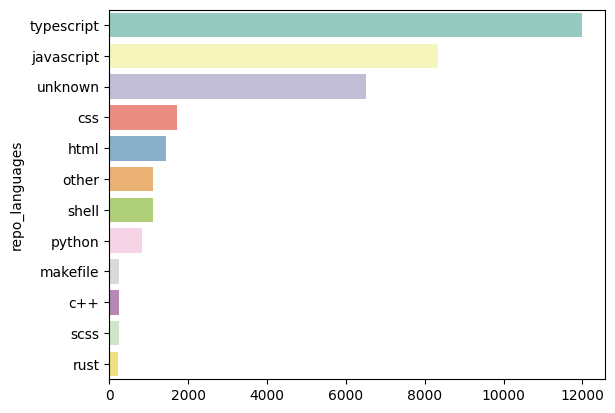

In [22]:
# ext_categories_counter
# ax=sns.barplot(y=repo_languages_counter_common.keys(), x=repo_languages_counter_common.values(), palette="Set3", hue=repo_languages_counter_common.keys(), legend="auto" )
ax=sns.barplot(y=repo_languages_counter_common.index, x=repo_languages_counter_common.values, palette="Set3", hue=repo_languages_counter_common.index, legend="auto" )

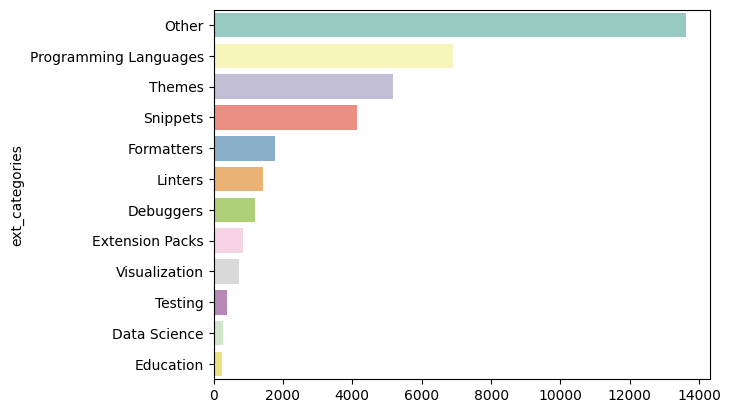

In [23]:
# ext_categories_counter
# ax=sns.barplot(y=ext_categories_counter_common.keys(), x=ext_categories_counter_common.values(), palette="Set3", hue=ext_categories_counter_common.keys(), legend="auto" )
ax=sns.barplot(y=ext_categories_counter_common.index, x=ext_categories_counter_common.values, palette="Set3", hue=ext_categories_counter_common.index, legend="auto" )

### Numerical variables

In [24]:
df.describe()

,ext_version,ext_install_count,ext_rating,total_vulners,critical__vulners,high__vulners,medium__vulners,low__vulners,repo_stars,repo_forks
count,3.792900e+04,3.792900e+04,37929.000000,37929.000000,37929.0,37929.000000,37929.000000,37929.000000,37929.000000,37929.000000
mean,5.508504e+02,4.968202e+05,2.750174,1.697066,0.0,0.155343,0.790424,0.751298,415.417807,66.702734
std,1.036739e+05,6.300951e+06,2.363453,12.642718,0.0,1.868902,7.311949,6.340346,6019.072547,1239.617970
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,5.150000e+02,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000e+00,2.174000e+03,4.170000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000,1.000000
75%,1.000000e+00,1.187800e+04,5.000000,0.000000,0.0,0.000000,0.000000,0.000000,18.000000,4.000000
max,2.019083e+07,1.778445e+08,5.000000,402.000000,0.0,92.000000,230.000000,323.000000,199089.000000,57209.000000


#### Shape of distribution

In [25]:
for column in cols_num:
    skewness_col = df[column].skew()
    kurtosis_col = df[column].kurtosis()

    print('==' * 20)
    print(f'Variable: {column}\n')
    print(f'Skew = {skewness_col}')
    print(f'Kurtosis = {kurtosis_col}')
    print('==' * 20)

    # print (f"Skewness/asymmetry of values in column '{column}': {skewness_col}")
    # print (f"Kurtosis/tailedness of values in column '{column}': {kurtosis_col}")
    print ()

Variable: ext_version

Skew = 194.7521475734619
Kurtosis = 37928.59917785546

Variable: ext_install_count

Skew = 20.357866421186483
Kurtosis = 482.98152359857113

Variable: ext_rating

Skew = -0.2459120769083387
Kurtosis = -1.86777696551205

Variable: total_vulners

Skew = 18.78137237994935
Kurtosis = 442.80695851778387

Variable: critical__vulners

Skew = 0.0
Kurtosis = 0.0

Variable: high__vulners

Skew = 32.07599442322883
Kurtosis = 1326.1371958675436

Variable: medium__vulners

Skew = 22.433168590469993
Kurtosis = 597.5803984435113

Variable: low__vulners

Skew = 29.017444932016332
Kurtosis = 1280.5255694927569

Variable: repo_stars

Skew = 26.719037352868444
Kurtosis = 771.7525261929592

Variable: repo_forks

Skew = 33.89351624442343
Kurtosis = 1261.0045036369042



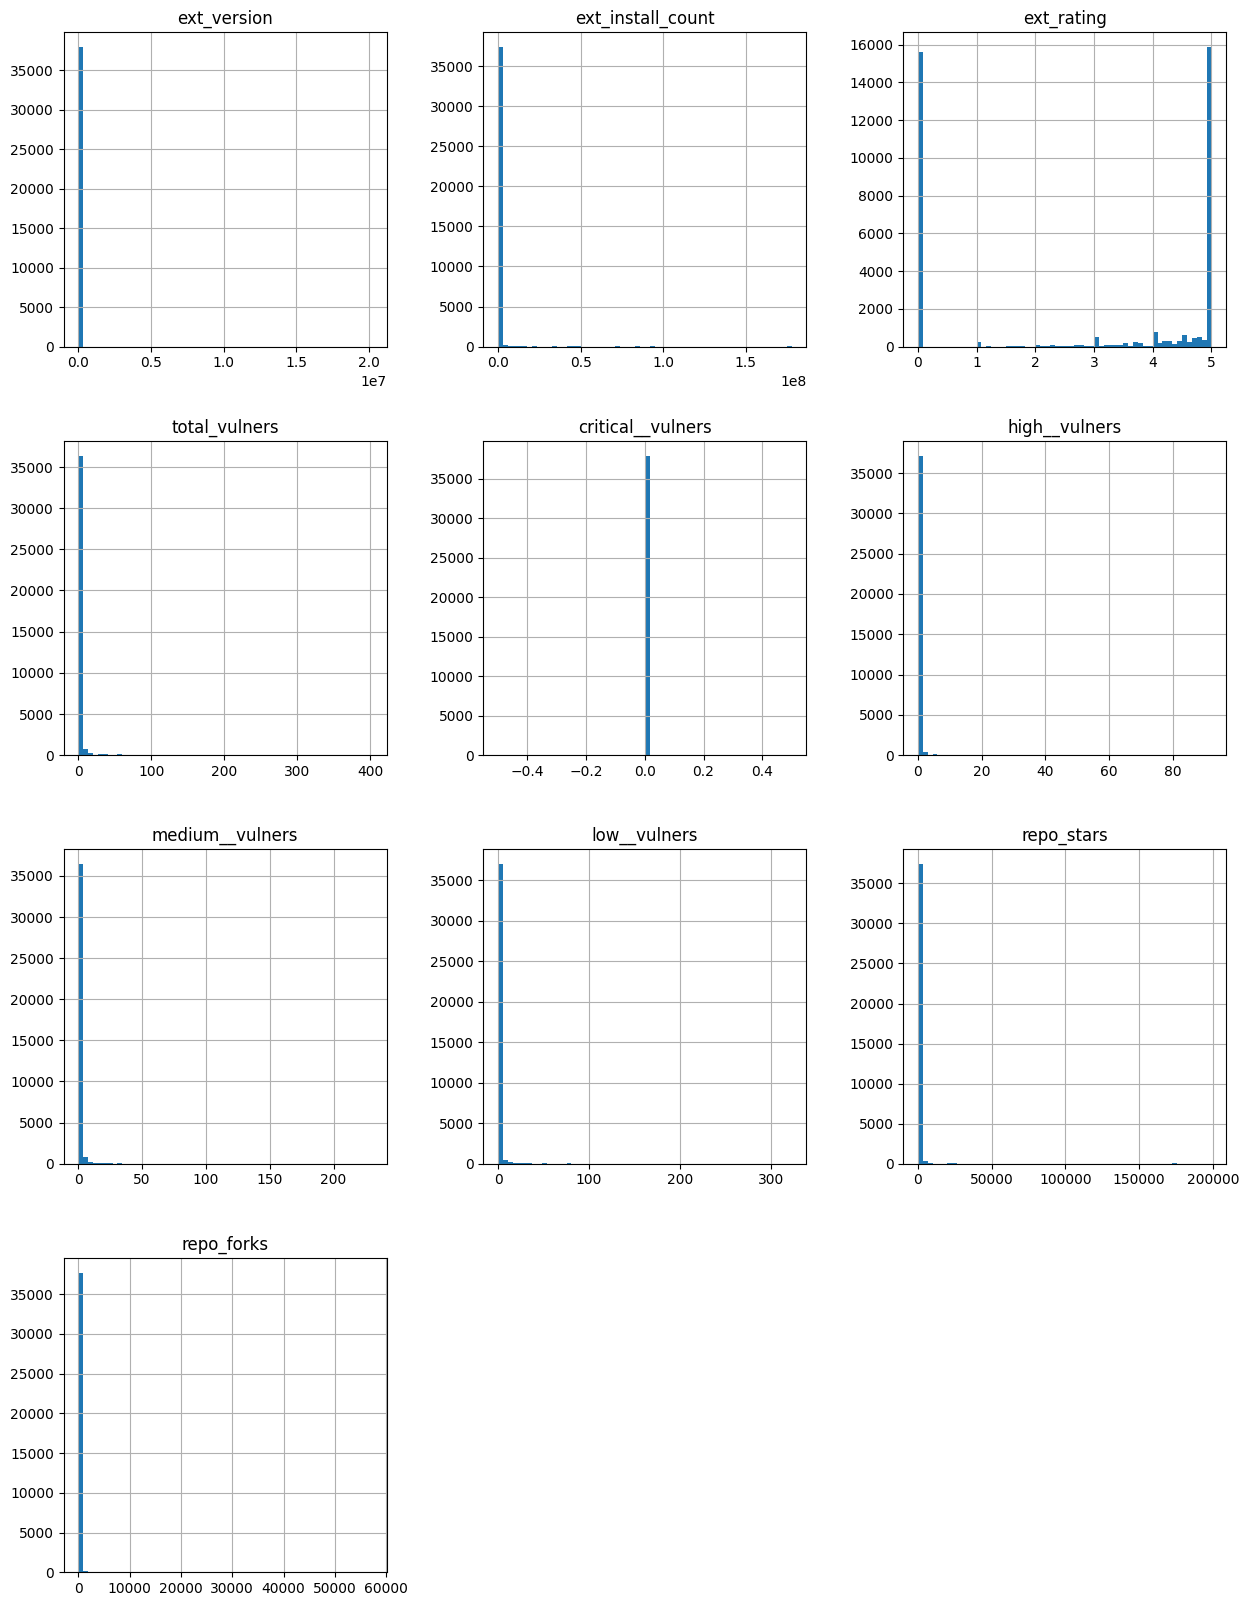

In [26]:
df[cols_num].hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10);

C:\Users\Gast\AppData\Local\Temp\ipykernel_14996\1224076742.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


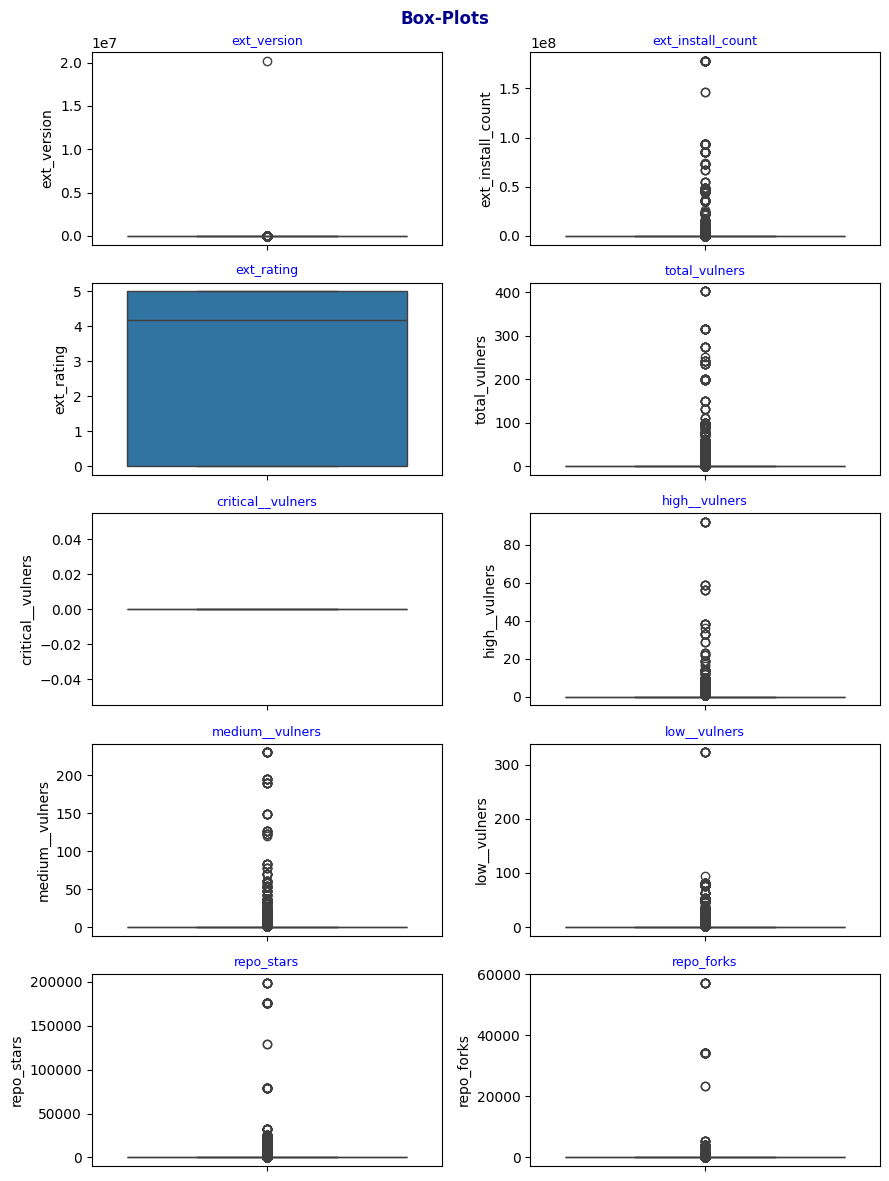

In [36]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (9, 12))
axes = axes.flat

for i,col in enumerate(cols_num):
    sns.boxplot(y = df[col],
                ax = axes[i])
    
    axes[i].set_title(f'{col}', fontsize = 9, color = "blue")
    axes[i].set_xlabel('')

fig.suptitle('Box-Plots', fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.tight_layout()
fig.show()

In [28]:
# for column in cols_num:
#     fig, ax = plt.subplots()#plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

#     sns.boxplot(y = df[column], color="lightblue")
#     ax.set_title(f"Boxplot of {column}")

#     plt.show()
    

### QQ-Plot to visualize Normal distribution of data


C:\Users\Gast\AppData\Local\Temp\ipykernel_14996\1130881617.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


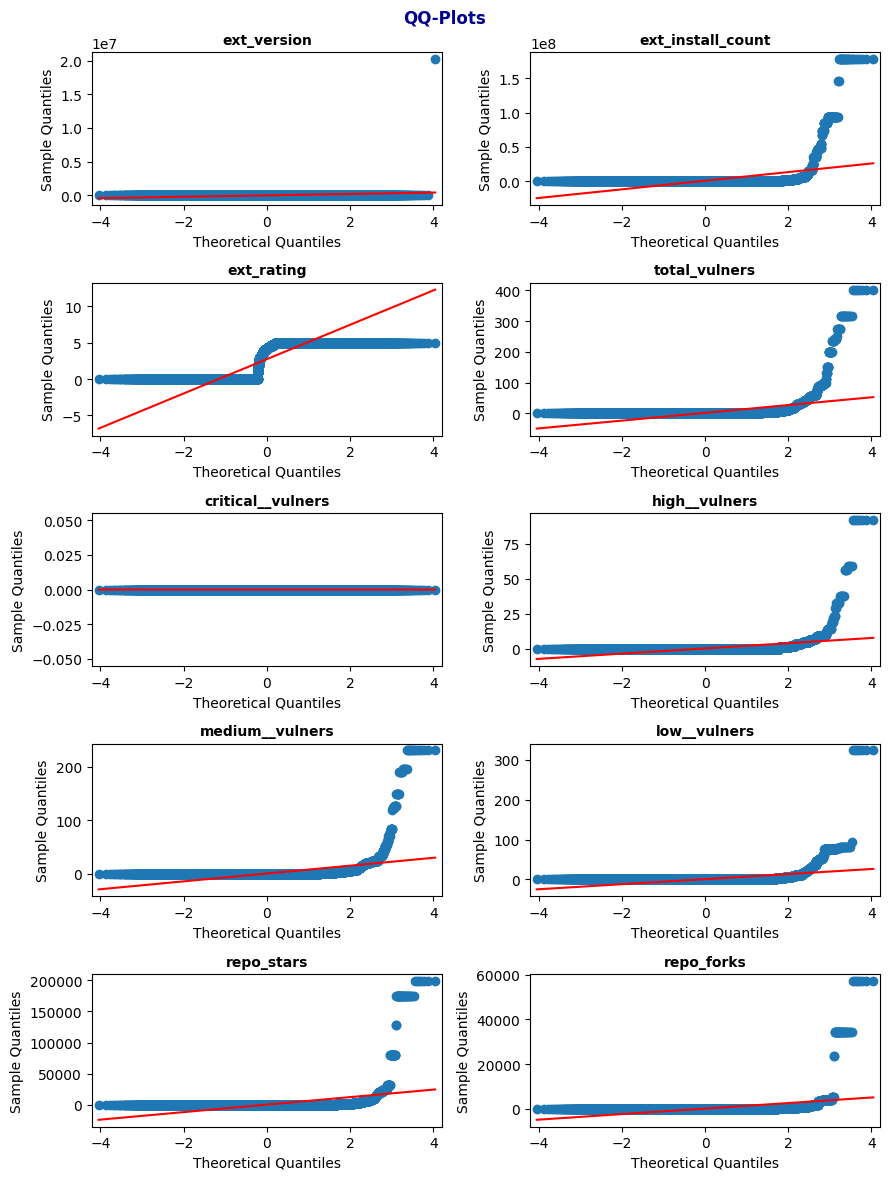

In [29]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (9, 12))
axes = axes.flat

for i,col in enumerate(cols_num):
    sm.qqplot(df[col], 
           line = 's', 
           ax = axes[i])
    
    axes[i].set_title(col, fontsize = 10, fontweight = 'bold', color = 'black')
    
# fig.delaxes(axes[7])
fig.suptitle('QQ-Plots', fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.tight_layout()
fig.show()

# sm.qqplot(df['SalePrice'], line='s');

Converting Continous to Discret

In [31]:
df["ext_rating"].value_counts(normalize=True).sort_values(ascending=False)

ext_rating
5.00    0.411110
0.00    0.410926
4.00    0.020090
3.00    0.012550
4.50    0.011100
          ...   
1.75    0.000026
2.21    0.000026
2.17    0.000026
1.71    0.000026
2.43    0.000026
Name: proportion, Length: 232, dtype: float64

In [32]:
# Discretizing 'SalePrice' into 4 categories
bins = [0, 1, 4, df["ext_rating"].max()]
labels = ["0", "1 - 4", "4 and above"]
df["ext_rating_category"] = pd.cut(df["ext_rating"], bins=bins, labels=labels, include_lowest=True)
df["ext_rating_category"].value_counts(normalize=True)

ext_rating_category
4 and above    0.505365
0              0.417675
1 - 4          0.076960
Name: proportion, dtype: float64

In [33]:
df["ext_version"].value_counts(normalize=True).sort_values(ascending=False)

ext_version
0           0.548894
1           0.325767
2           0.066545
3           0.023913
4           0.008727
2025        0.005088
5           0.003770
8           0.002188
6           0.002004
7           0.001714
9           0.001134
10          0.001055
2023        0.001028
2024        0.000976
23          0.000923
25          0.000817
19          0.000633
18          0.000554
16          0.000422
17          0.000422
1001        0.000369
20          0.000343
2022        0.000316
12          0.000264
2002        0.000211
24          0.000211
2026        0.000211
44          0.000185
11          0.000185
109         0.000158
100         0.000105
41          0.000105
21          0.000105
13          0.000105
2020        0.000079
64          0.000079
88          0.000079
2021        0.000053
21300       0.000053
103         0.000053
27          0.000053
2019        0.000026
2018        0.000026
20190831    0.000026
26          0.000026
Name: proportion, dtype: float64

In [34]:
bins = [0, 1, 4, df["ext_version"].max()]
labels = ["0", "1 - 4", "4 and above"]
df["ext_version_category"] = pd.cut(df["ext_version"], bins=bins, labels=labels, include_lowest=True)
df["ext_version_category"].value_counts(normalize=True)

ext_version_category
0              0.874661
1 - 4          0.099185
4 and above    0.026154
Name: proportion, dtype: float64

In [ ]:
df_univariate = df.copy()
df_univariate

### Bivariate Analysis